In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import GPy
import pickle

plt.style.use('hfs')

def sampled_LC_params(t, V, alpha=0.01):
    _mag_interp=V
    _time_interp = t

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]
    ax1.plot(_time_interp, _mag_interp, c='k', label='GP', alpha=alpha)
    
    x_30_40 = np.atleast_2d(np.array([30, 40])).T
    mag_30_40, __ = m.predict(x_30_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_30_40[1]-mag_30_40[0])
    ax1.axvline(_time_interp[_ind_tmax],c='k', label='t_max', alpha=alpha)
    ax1.axvline(x_30_40[0],c='k', ls=':', alpha=alpha)
    ax1.axvline(x_30_40[1],c='k', ls=':', alpha=alpha)

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':',label='t_dm1', alpha=alpha)

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--', label='t_dm2', alpha=alpha)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]


In [2]:
data = pd.read_csv('../Data/II_clean_sample.dat', index_col=0)
data.event.unique()

array(['SN2013ej', 'SN2012aw', 'SN1999em', 'SN2014cx', 'SN2004er',
       'SN2009ib', 'SN2013fs', 'SN2009N', 'SN2014G', 'SN2003hn',
       'SN2008aw', 'SN1999gi', 'SN1992ba', 'SN2013ai'], dtype=object)

In [3]:
results=pd.read_csv('params_best_GP_II.dat', index_col=0)

In [4]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2013ej,56497.5,9.417466,5.260729,10.043211,0.306615
SN2012aw,56002.0,13.785238,22.787619,29.848571,0.052489
SN1999em,51476.5,2.510000,12.442857,5.264286,0.001882
SN2014cx,56896.9,12.542602,12.654393,17.890694,0.080702
SN2004er,53271.8,12.830952,13.514286,6.757143,0.138826
SN2009ib,55045.0,11.908271,27.172932,32.189474,0.059805
SN2013fs,56570.8,7.456258,21.184787,23.881033,0.116049
SN2009N,54845.4,12.118250,1.251947,1.877921,-0.013449
SN2014G,56669.6,12.385940,28.667820,30.290526,0.320540


In [5]:
sn='SN1992ba'
data=data[data.event==sn].drop('event',axis=1)

In [6]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0
y=np.atleast_2d(data.V).T
X=np.atleast_2d(t_norm).T

err = data.Verr
err = err.replace(np.nan,data.Verr.mean()).values

length_scale=np.mean(t_norm) 
variance=np.sqrt(np.std(t_norm))
                 
k_rbf = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=length_scale)
k_matern = GPy.kern.Matern32(1)
k_lin = GPy.kern.Linear(1)
k_white = GPy.kern.White(1, GPy.util.linalg.tdot(err))
k_bias = GPy.kern.Bias(1, GPy.util.linalg.tdot(err))

In [7]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),200)).T

In [8]:
n=100

In [9]:
m_rbf = GPy.models.GPRegression(X,y,k_rbf)
__ = m_rbf.optimize ()
__ = m_rbf.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

(20.0, 14.0)

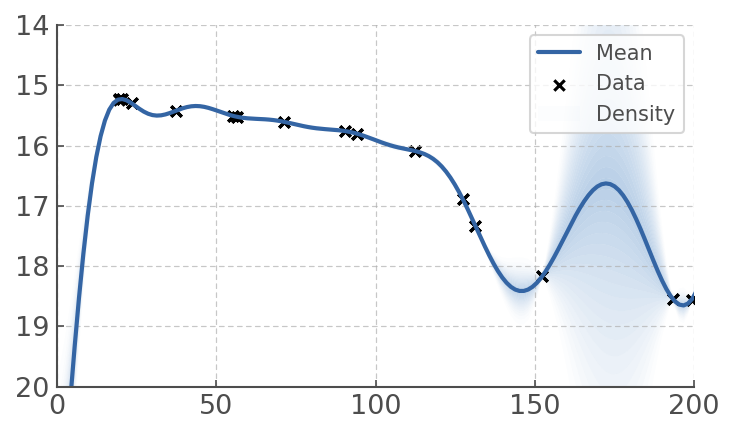

In [10]:
m_rbf.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,200])
plt.ylim([20,14])

In [11]:
m = GPy.models.GPRegression(X,y,k_matern)
__ = m.optimize ()
__ = m.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

(20.0, 14.0)

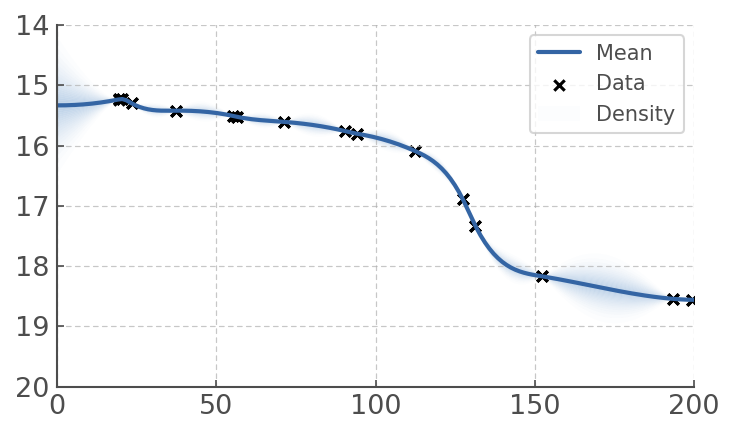

In [12]:
m.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,200])
plt.ylim([20,14])

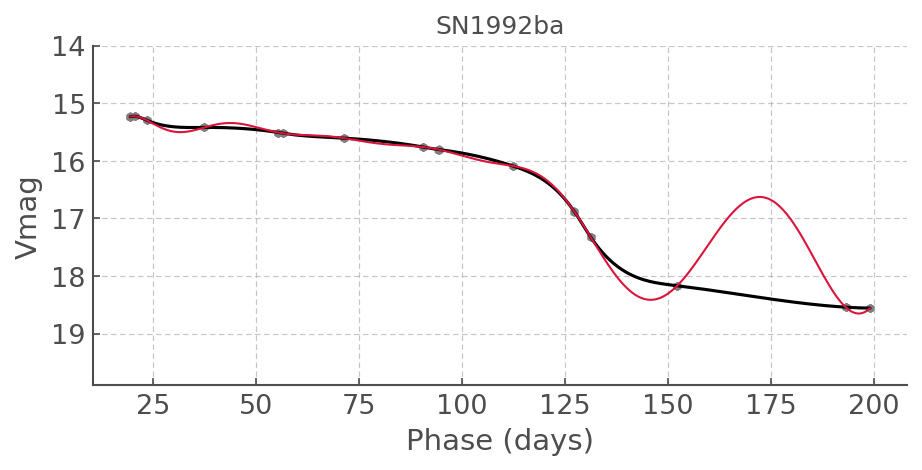

In [13]:
f, ax = plt.subplots(nrows=1, figsize=(7,3))

x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_time_interp = x.T[0]

_mag_interp0, sigma0 = m_rbf.predict(x)

_mag_interp1, sigma1 = m.predict(x)

ax.plot(x, _mag_interp1, c='k')
ax.plot(x, _mag_interp0, c='crimson', zorder=2000, lw=1)

ax.scatter(t_norm, y, color='grey', marker='h',s=10)
ax.invert_yaxis()
ax.set_ylim([19.9,14])

ax.set_ylabel('Vmag')
ax.set_xlabel('Phase (days)')
plt.title(f'{sn}',fontsize=12)
plt.savefig('92ba_gpy_kernels.png', bbox_inches='tight')

In [14]:
_file = open(f'{sn}.gpym', 'wb')
pickle.dump(m, _file)
_file.close()

<ErrorbarContainer object of 3 artists>

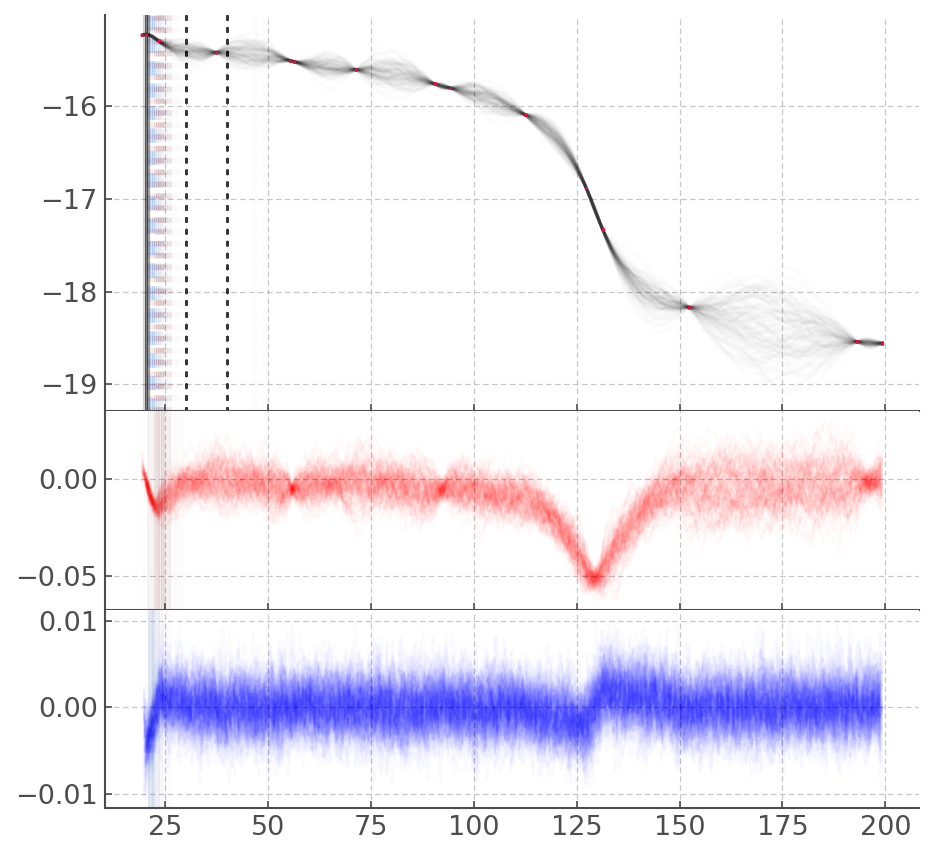

In [15]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])


list_params = []

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    _params = sampled_LC_params(t=t[:,0], V=_v_i, alpha=0.01)
    list_params.append(list(_params))
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ', zorder=1000, 
             color='crimson')

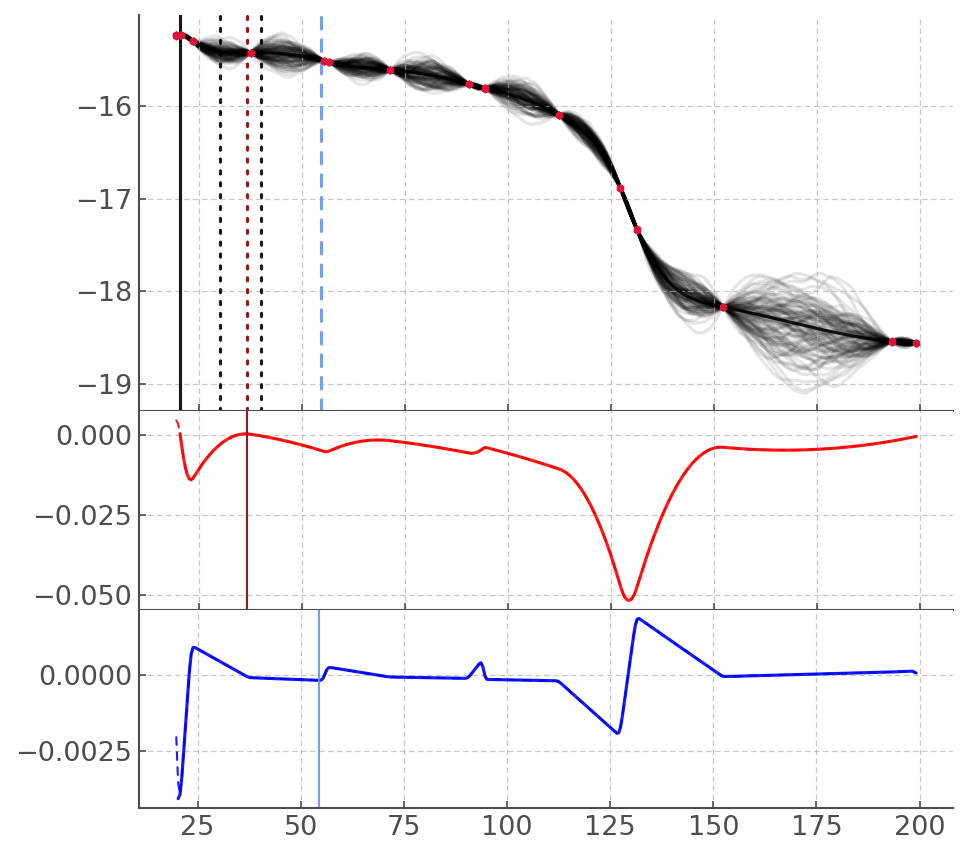

In [16]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

_params = sampled_LC_params(t=t[:,0], V=_mag_interp, alpha=0.9)
    
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    ax1.plot(t[:,0], _v_i, alpha=0.1, c='k', zorder=0.1)

In [17]:
results.loc[sn].iloc[0] = data.texp.iloc[0]
results.loc[sn].iloc[1:] = _params
results.to_csv('params_best_GP_II.dat')

In [18]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2013ej,56497.5,9.417466,5.260729,10.043211,0.306615
SN2012aw,56002.0,13.785238,22.787619,29.848571,0.052489
SN1999em,51476.5,2.510000,12.442857,5.264286,0.001882
SN2014cx,56896.9,12.542602,12.654393,17.890694,0.080702
SN2004er,53271.8,12.830952,13.514286,6.757143,0.138826
SN2009ib,55045.0,11.908271,27.172932,32.189474,0.059805
SN2013fs,56570.8,7.456258,21.184787,23.881033,0.116049
SN2009N,54845.4,12.118250,1.251947,1.877921,-0.013449
SN2014G,56669.6,12.385940,28.667820,30.290526,0.320540


# SKLEARN

In [19]:
from sklearn import gaussian_process as sklgp

results_SKL=pd.read_csv('params_best_GP_II_SKL.dat', index_col=0)

def sampled_LC_params(m, t, alpha=0.01, ax1 = None, ax2 = None, ax3 = None, size=100):
    
    try:
        _mag_interp, sigma = m.predict(t, full_cov=True) # GPy implementation
        _mag_interp=_mag_interp[:,0]*-1
    except TypeError:
        _mag_interp, sigma = m.predict(t, return_cov=True) # sklearn implementation
        _mag_interp=_mag_interp*-1
    
    _time_interp = t[:,0]

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]

    ax1.plot(_time_interp, _mag_interp*-1, c='k', label='GP', alpha=alpha, zorder=10000)
    
    
    x_30 = np.atleast_2d(np.array([30])).T
    x_40 = np.atleast_2d(np.array([40])).T

    mag_30 =  m.predict(x_30)
    mag_40 =  m.predict(x_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_40-mag_30)
    ax1.axvline(_time_interp[_ind_tmax],c='grey', lw=1, alpha=alpha, label='t$_{max}$')
    ax1.axvline(x_30,c='k', ls=':', alpha=0.5, label='+30 days')
    ax1.axvline(x_40,c='k', ls=':', alpha=0.8, label='+40 days')

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':', alpha=alpha, label='dm1')

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--',  alpha=alpha, label='dm2')
    
    ## Sampling to show uncertianties
    test = np.random.multivariate_normal(_mag_interp,  sigma, size=size)
    for i in range(test.shape[0]):
        _v_i = test[i,:]
        ax1.plot(_time_interp , _v_i*-1, alpha=0.01, zorder=0.1, color='k')
        _grad1 = np.gradient(_v_i)
        ax2.plot(_time_interp, _grad1, color='r', alpha=0.01)
        _grad2 = np.gradient(_grad1)
        ax3.plot(_time_interp, _grad2, color='b', alpha=0.01)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]

In [20]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0

y=data.V.values
X=np.atleast_2d(t_norm).T

err = data.Verr.values
                 
k_rbf = sklgp.kernels.RBF(length_scale_bounds=(10,200)) 
k_matern = sklgp.kernels.Matern(length_scale_bounds=(1,100),  nu=1.5) 
k_white = sklgp.kernels.WhiteKernel(0.1)
k_rq = sklgp.kernels.RationalQuadratic(length_scale_bounds=(100,200), alpha=0.2) 

In [21]:
#k_rbf1 = sklgp.kernels.RBF(length_scale_bounds=(80,100)) 
k_rbf2= sklgp.kernels.RBF(length_scale_bounds=(120,500)) 

In [22]:
gp = sklgp.GaussianProcessRegressor(kernel=k_rbf2, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=100)

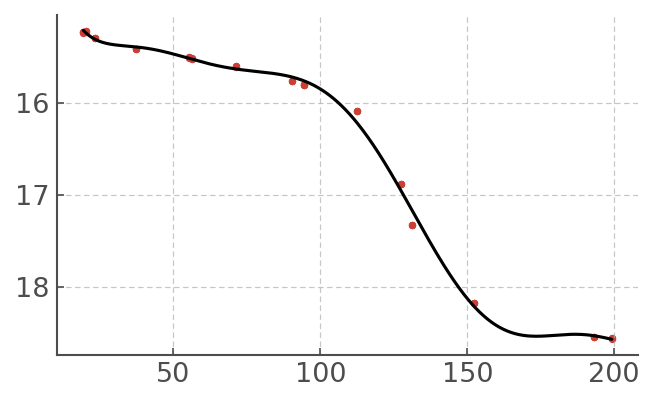

In [23]:
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()

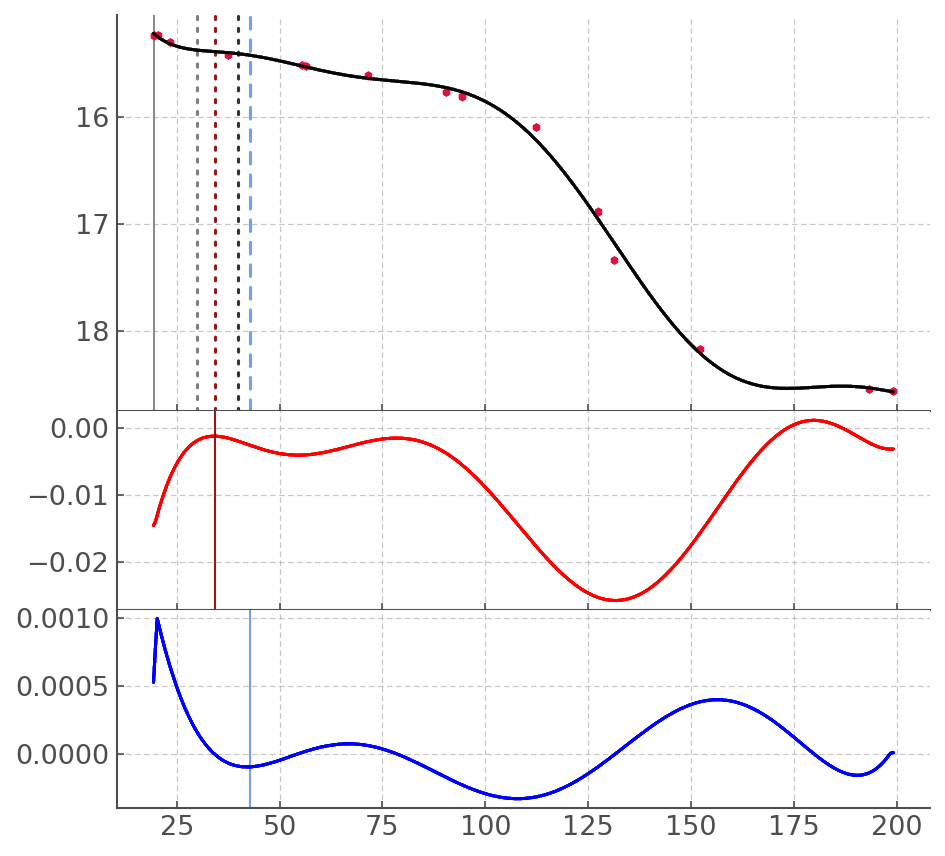

In [24]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = gp.predict(x, return_cov=True)
_time_interp = x.T[0]

_mag_interp=_mag_interp[:]

_params = sampled_LC_params(t=t, m=gp, alpha=0.9, ax1=ax1, ax2=ax2, ax3=ax3)
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

ax1.invert_yaxis()

In [25]:
results_SKL.loc[sn].iloc[0] = data.texp.iloc[0]
results_SKL.loc[sn].iloc[1:] = _params
results_SKL.to_csv('params_best_GP_II_SKL.dat')